# Data Cleaning and Data Analysis on Covid-19 dataset (India).

![corona](https://c.files.bbci.co.uk/14A35/production/_115033548_gettyimages-1226314512.jpg)



In [185]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import missingno
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/covid19-in-india/StatewiseTestingDetails.csv
/kaggle/input/covid19-in-india/covid_19_india.csv
/kaggle/input/india-states/Igismap/Indian_States.shp
/kaggle/input/india-states/Igismap/Indian_States.prj
/kaggle/input/india-states/Igismap/Indian_States.dbf
/kaggle/input/india-states/Igismap/Indian_States.shx


## Loading the dataset.

In [186]:
data = pd.read_csv("/kaggle/input/covid19-in-india/covid_19_india.csv",index_col=0)

### **We will be analyzing the data of Covid-19 spread over the Indian states. The data ranges from 01-January-2020 to 26-November-2020.**

In [187]:
data = data.iloc[:8835]

In [188]:
data.head()

,Date,Time,State/UnionTerritory,ConfirmedIndianNational,ConfirmedForeignNational,Cured,Deaths,Confirmed
Sno,,,,,,,,
1,30/01/20,6:00 PM,Kerala,1,0,0,0,1
2,31/01/20,6:00 PM,Kerala,1,0,0,0,1
3,01/02/20,6:00 PM,Kerala,2,0,0,0,2
4,02/02/20,6:00 PM,Kerala,3,0,0,0,3
5,03/02/20,6:00 PM,Kerala,3,0,0,0,3


### Exploring the missing values in the dataset using missingno package and info of the dataset.

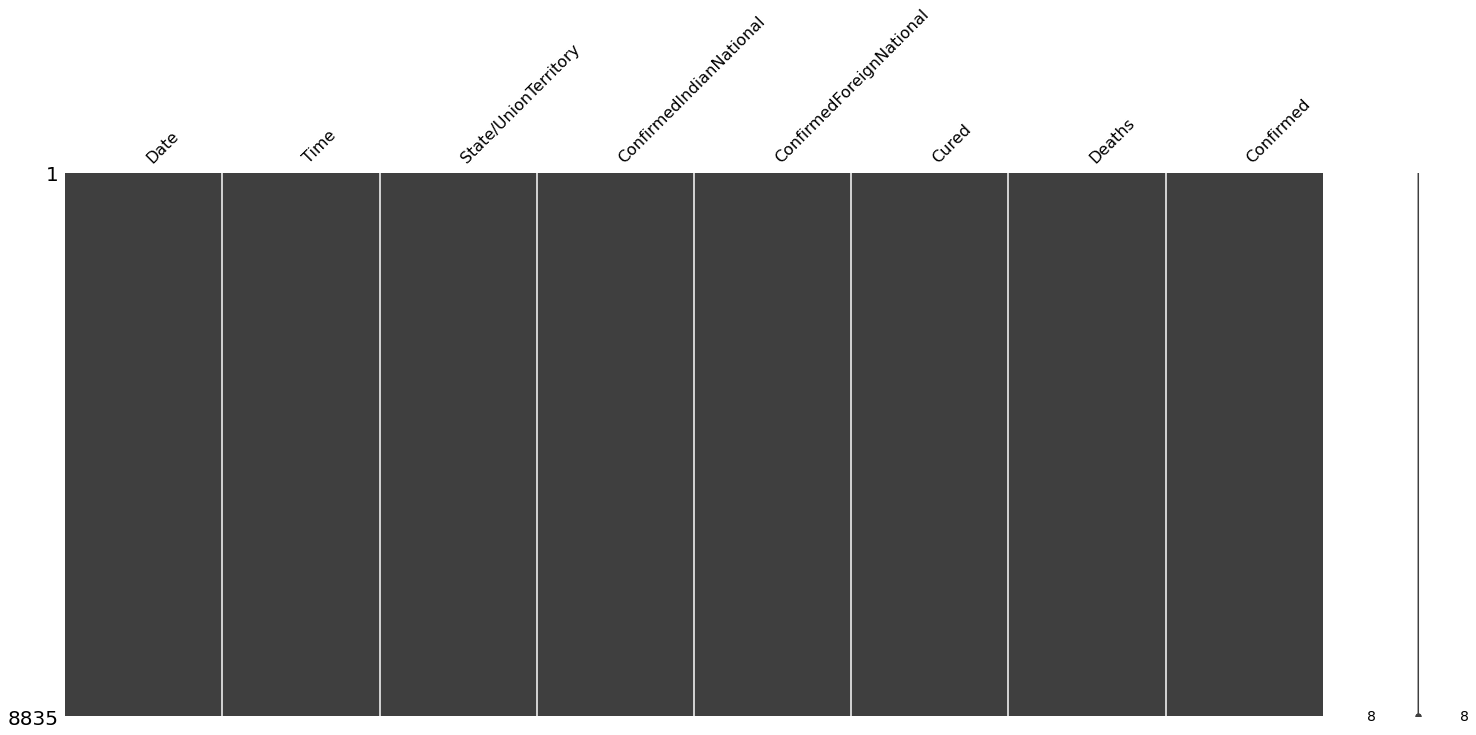

In [189]:
missingno.matrix(data)

### Checking duplicated values in the dataset.

In [190]:
data.duplicated().sum()

0

In [191]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8835 entries, 1 to 8835
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Date                      8835 non-null   object
 1   Time                      8835 non-null   object
 2   State/UnionTerritory      8835 non-null   object
 3   ConfirmedIndianNational   8835 non-null   object
 4   ConfirmedForeignNational  8835 non-null   object
 5   Cured                     8835 non-null   int64 
 6   Deaths                    8835 non-null   int64 
 7   Confirmed                 8835 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 621.2+ KB


### Now we are looking for unique timestamps given in the dataset, further we will merge the ***date*** and the ***time*** columns.

In [192]:
data['Time'].unique()

array(['6:00 PM', '10:00 AM', '7:30 PM', '9:30 PM', '8:30 PM', '5:00 PM',
       '8:00 AM'], dtype=object)

In [193]:
data.rename(columns={"Date" : "Datetime"},inplace=True)

### Convert the Datetime column to dtype of datetime64[ns]

In [194]:
def timeconv(df):
    alltime = []
    for i in df["Time"]:
        mer = i[-2:]
        
        time = i[:-3]
        if len(time) ==4:
            time = "0"+time
        if mer == "PM":
            time = str(12+int(time[:2]))+time[-3:]
        alltime.append(time)
    assert df.shape[0] == len(alltime)
    df['Datetime'] = df['Datetime'] +" "+ pd.Series(alltime)
            
       
        
        
timeconv(data)

In [195]:
data.drop(["Time"],axis=1,inplace = True)

In [196]:
data["Datetime"] = pd.to_datetime(data["Datetime"])

In [197]:
timest = data.iloc[-2]["Datetime"]
data.iloc[-1,0] = timest

### We discovered that there are several missing values marked as "-", let's take a look.

In [198]:
data

,Datetime,State/UnionTerritory,ConfirmedIndianNational,ConfirmedForeignNational,Cured,Deaths,Confirmed
Sno,,,,,,,
1,2020-01-30 18:00:00,Kerala,1,0,0,0,1
2,2020-01-31 18:00:00,Kerala,1,0,0,0,1
3,2020-01-02 18:00:00,Kerala,2,0,0,0,2
4,2020-02-02 18:00:00,Kerala,3,0,0,0,3
5,2020-03-02 18:00:00,Kerala,3,0,0,0,3
...,...,...,...,...,...,...,...
8831,2020-11-26 08:00:00,Tamil Nadu,-,-,751535,11655,774710
8832,2020-11-26 08:00:00,Telengana,-,-,254676,1444,266904
8833,2020-11-26 08:00:00,Tripura,-,-,31441,370,32578


In [199]:
l = data.groupby('State/UnionTerritory')

In [200]:
data = data.replace("-",np.nan)

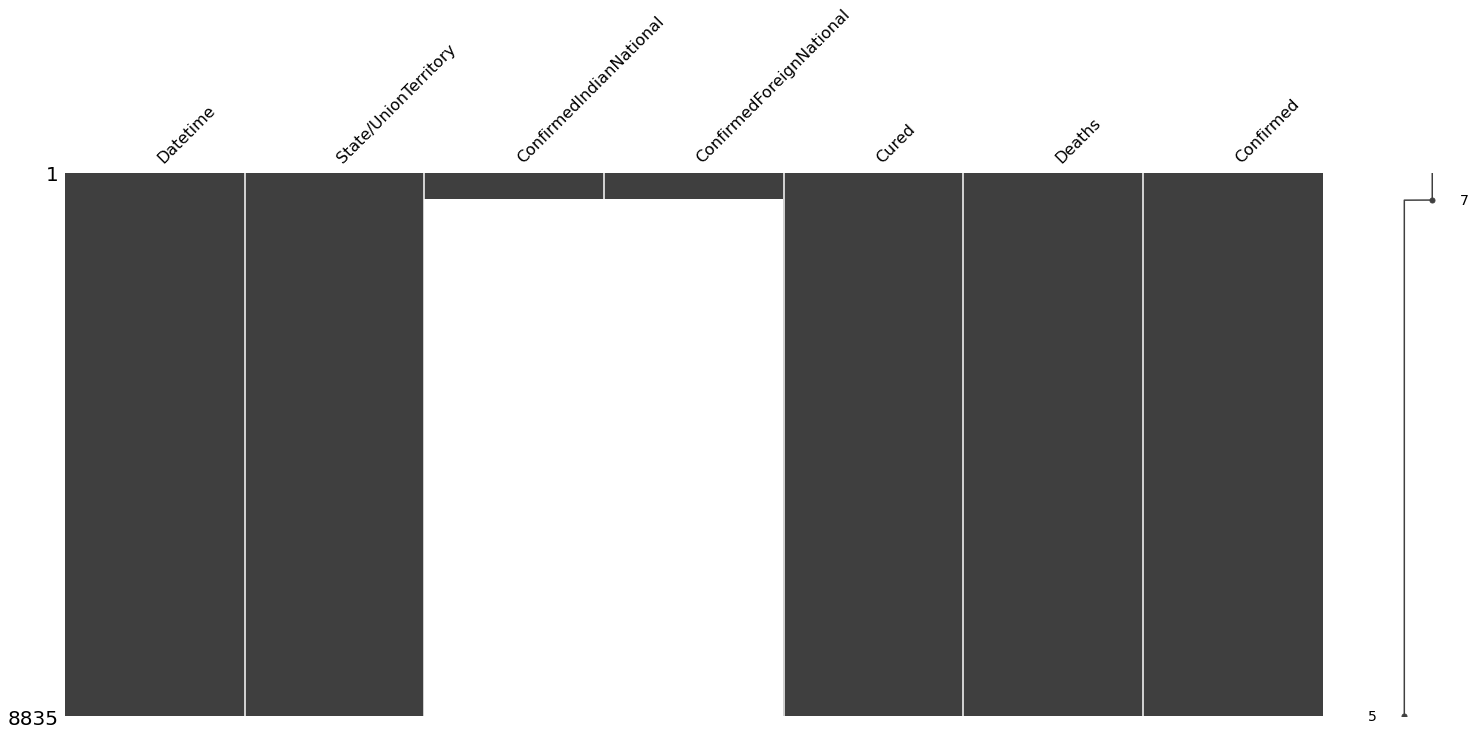

In [201]:
missingno.matrix(data)

### Whoa! most of the values are missing in 3rd and 4th column, we better drop those columns for now.

In [202]:
data.drop(list(data.columns)[2:4],axis=1,inplace = True)

### Moving forward, let's take a look at distinct state names for further analysis.

In [203]:
data['State/UnionTerritory'].unique()

array(['Kerala', 'Telengana', 'Delhi', 'Rajasthan', 'Uttar Pradesh',
       'Haryana', 'Ladakh', 'Tamil Nadu', 'Karnataka', 'Maharashtra',
       'Punjab', 'Jammu and Kashmir', 'Andhra Pradesh', 'Uttarakhand',
       'Odisha', 'Puducherry', 'West Bengal', 'Chhattisgarh',
       'Chandigarh', 'Gujarat', 'Himachal Pradesh', 'Madhya Pradesh',
       'Bihar', 'Manipur', 'Mizoram', 'Andaman and Nicobar Islands',
       'Goa', 'Unassigned', 'Assam', 'Jharkhand', 'Arunachal Pradesh',
       'Tripura', 'Nagaland', 'Meghalaya', 'Dadar Nagar Haveli',
       'Cases being reassigned to states', 'Sikkim', 'Daman & Diu',
       'Dadra and Nagar Haveli and Daman and Diu', 'Telangana',
       'Telangana***', 'Telengana***', 'Maharashtra***', 'Chandigarh***',
       'Punjab***'], dtype=object)

### Keeping it simple, we will drop the rows with state name ending with "***" as it is seems to be rows with incomplete values.

In [204]:
def drop_star(df):
    for i in df['State/UnionTerritory'].iteritems():
        if i[1][-3:] == "***":
            df.drop(i[0],inplace=True)
        
drop_star(data)
data['State/UnionTerritory'].unique()

array(['Kerala', 'Telengana', 'Delhi', 'Rajasthan', 'Uttar Pradesh',
       'Haryana', 'Ladakh', 'Tamil Nadu', 'Karnataka', 'Maharashtra',
       'Punjab', 'Jammu and Kashmir', 'Andhra Pradesh', 'Uttarakhand',
       'Odisha', 'Puducherry', 'West Bengal', 'Chhattisgarh',
       'Chandigarh', 'Gujarat', 'Himachal Pradesh', 'Madhya Pradesh',
       'Bihar', 'Manipur', 'Mizoram', 'Andaman and Nicobar Islands',
       'Goa', 'Unassigned', 'Assam', 'Jharkhand', 'Arunachal Pradesh',
       'Tripura', 'Nagaland', 'Meghalaya', 'Dadar Nagar Haveli',
       'Cases being reassigned to states', 'Sikkim', 'Daman & Diu',
       'Dadra and Nagar Haveli and Daman and Diu', 'Telangana'],
      dtype=object)

### There are still several typos in state names, we will deal with this manually.

In [205]:
data.drop(data[(data['State/UnionTerritory']=='Telangana')|(data['State/UnionTerritory']=='Daman & Diu')|(data['State/UnionTerritory']=='Dadar Nagar Haveli')].index,inplace=True)
data['State/UnionTerritory'].unique()

array(['Kerala', 'Telengana', 'Delhi', 'Rajasthan', 'Uttar Pradesh',
       'Haryana', 'Ladakh', 'Tamil Nadu', 'Karnataka', 'Maharashtra',
       'Punjab', 'Jammu and Kashmir', 'Andhra Pradesh', 'Uttarakhand',
       'Odisha', 'Puducherry', 'West Bengal', 'Chhattisgarh',
       'Chandigarh', 'Gujarat', 'Himachal Pradesh', 'Madhya Pradesh',
       'Bihar', 'Manipur', 'Mizoram', 'Andaman and Nicobar Islands',
       'Goa', 'Unassigned', 'Assam', 'Jharkhand', 'Arunachal Pradesh',
       'Tripura', 'Nagaland', 'Meghalaya',
       'Cases being reassigned to states', 'Sikkim',
       'Dadra and Nagar Haveli and Daman and Diu'], dtype=object)

In [206]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8747 entries, 1 to 8835
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Datetime              8747 non-null   datetime64[ns]
 1   State/UnionTerritory  8747 non-null   object        
 2   Cured                 8747 non-null   int64         
 3   Deaths                8747 non-null   int64         
 4   Confirmed             8747 non-null   int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 410.0+ KB


In [207]:
data[data['State/UnionTerritory']=='Tripura']

,Datetime,State/UnionTerritory,Cured,Deaths,Confirmed
Sno,,,,,
736,2020-07-04 18:00:00,Tripura,0,0,1
767,2020-08-04 17:00:00,Tripura,0,0,1
798,2020-09-04 17:00:00,Tripura,0,0,1
829,2020-10-04 17:00:00,Tripura,0,0,1
860,2020-11-04 17:00:00,Tripura,0,0,2
...,...,...,...,...,...
8693,2020-11-22 08:00:00,Tripura,31179,366,32415
8728,2020-11-23 08:00:00,Tripura,31269,369,32434
8763,2020-11-24 08:00:00,Tripura,31296,370,32493


### Extracting the latest insights from the data, we will later visualize the trends.

In [208]:
l = data.groupby('State/UnionTerritory')
current = l.last()

In [209]:
current

,Datetime,Cured,Deaths,Confirmed
State/UnionTerritory,,,,
Andaman and Nicobar Islands,2020-11-26 08:00:00,4479,61,4677
Andhra Pradesh,2020-11-26 08:00:00,845039,6962,864674
Arunachal Pradesh,2020-11-26 08:00:00,15157,49,16174
Assam,2020-11-26 08:00:00,207766,978,212021
Bihar,2020-11-26 08:00:00,225077,1237,231539
Cases being reassigned to states,2020-07-18 08:00:00,0,0,163
Chandigarh,2020-11-26 08:00:00,15532,266,16925
Chhattisgarh,2020-11-26 08:00:00,201744,2783,229203
Dadra and Nagar Haveli and Daman and Diu,2020-11-26 08:00:00,3290,2,3327


### Plotting a bar plot to show the spread of Covid-19 across the states in decreasing order.

[Text(0, 0, '0'),
 Text(0, 0, '250000'),
 Text(0, 0, '500000'),
 Text(0, 0, '750000'),
 Text(0, 0, '1000000'),
 Text(0, 0, '1250000'),
 Text(0, 0, '1500000'),
 Text(0, 0, '1750000'),
 Text(0, 0, '2000000')]

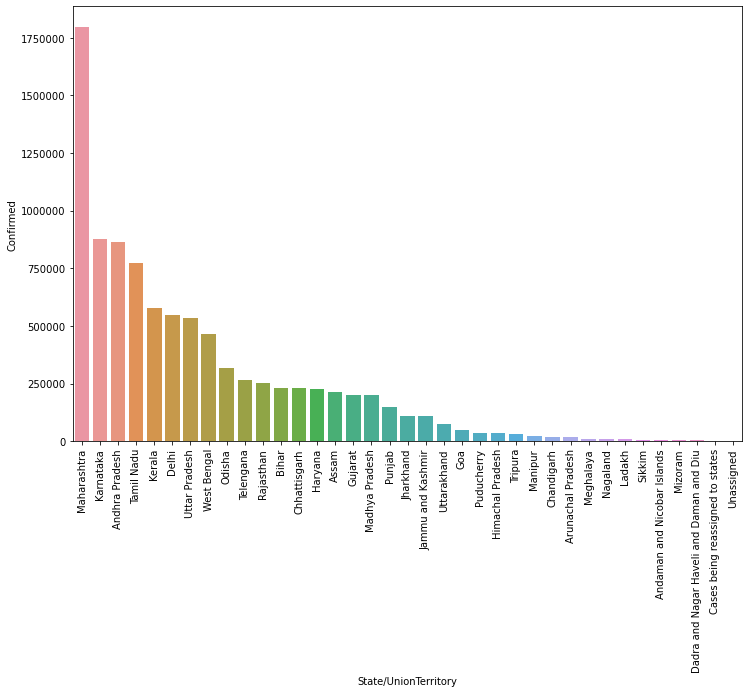

In [210]:
fig ,ax = plt.subplots(figsize= (12,8))
fig.set_facecolor("white")
current = current.sort_values("Confirmed",ascending=False)
p = sns.barplot(ax=ax,x= current.index,y=current['Confirmed'])
p.set_xticklabels(labels = current.index,rotation=90)

p.set_yticklabels(labels=(p.get_yticks()*1).astype(int))


### Now let's look at the Cured/Death ratio of these states using pie plot.

[]

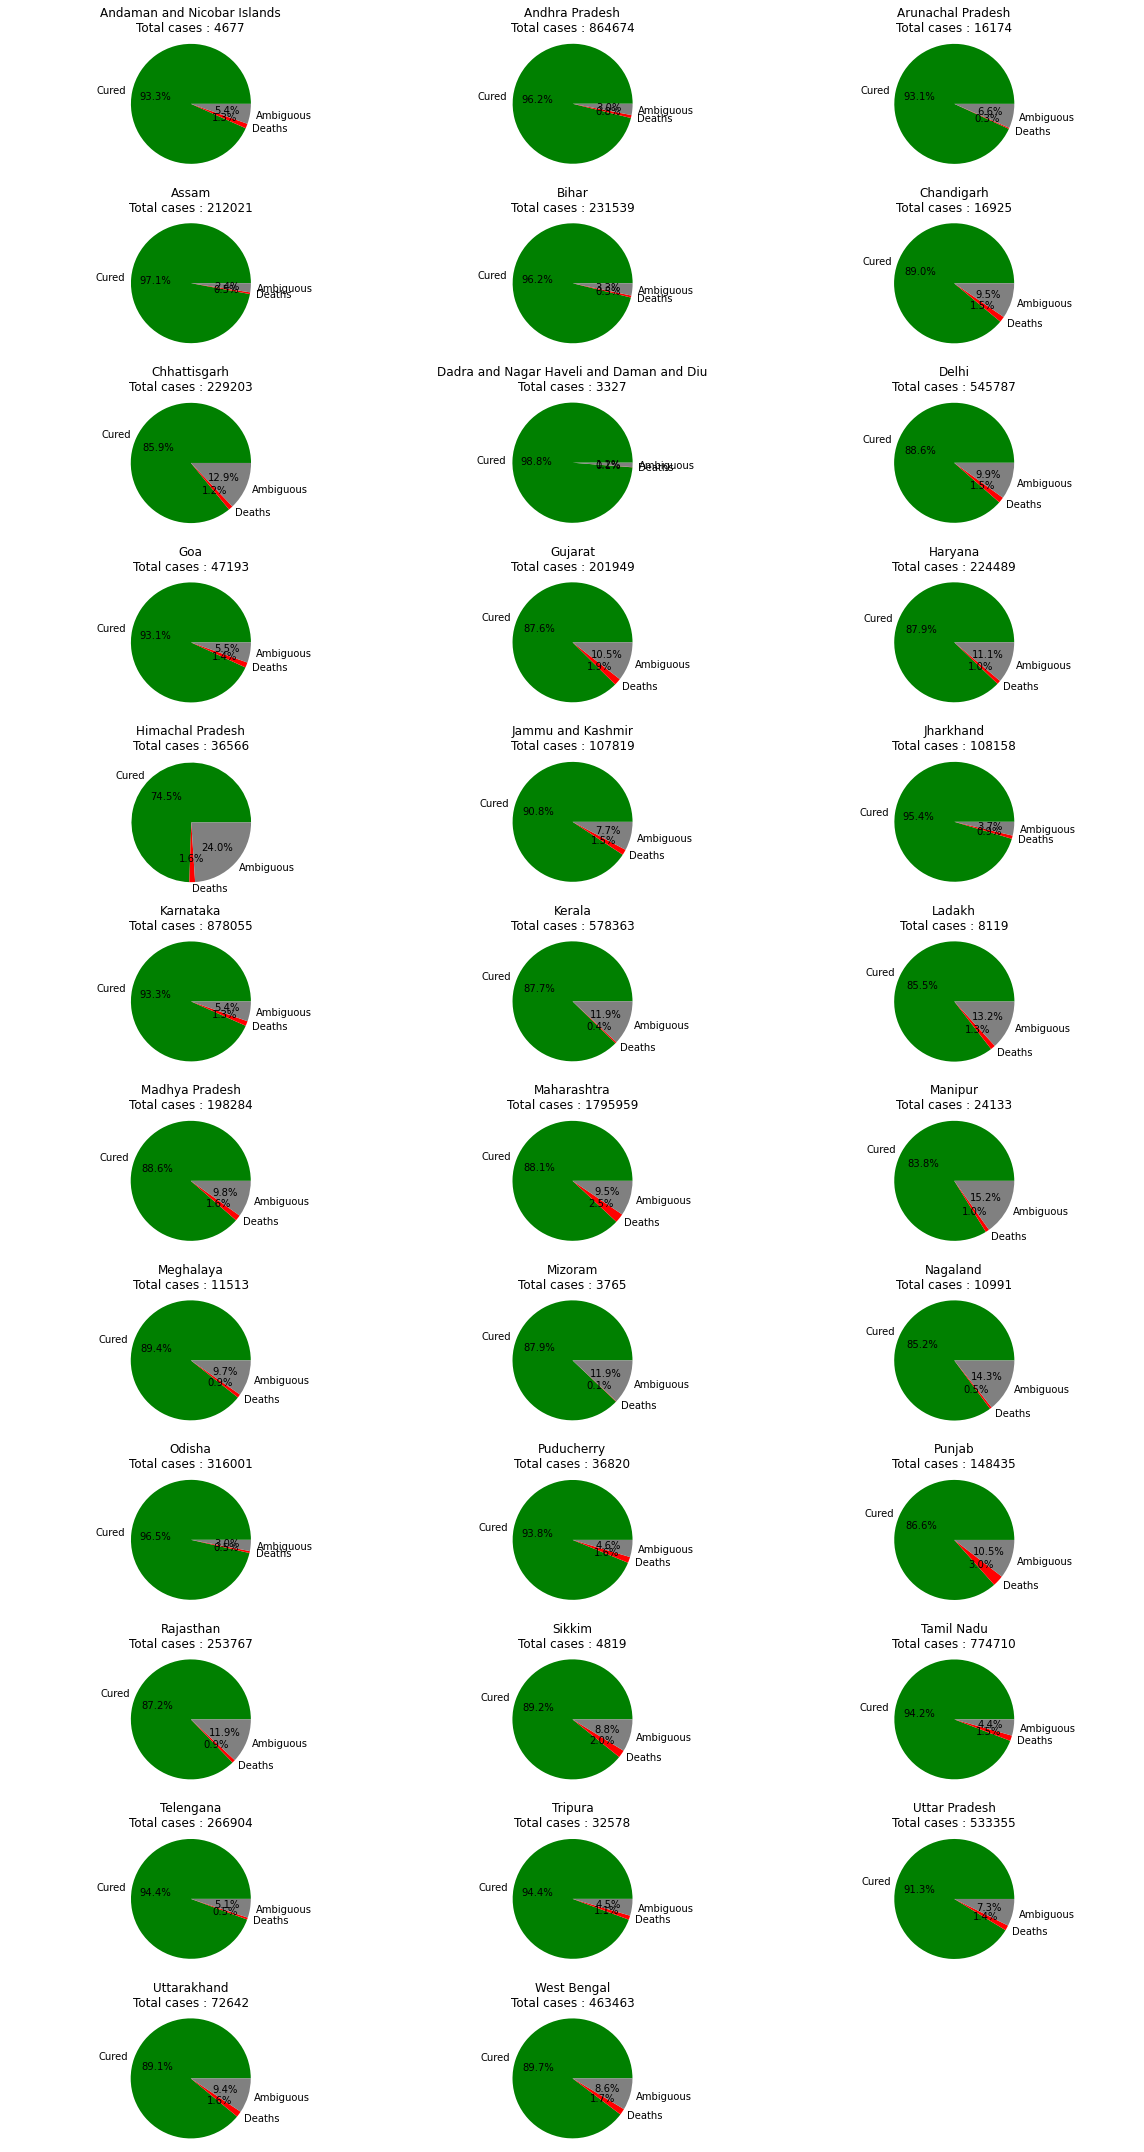

In [211]:
fig, axs = plt.subplots(12,3, figsize=(16,30))
fig.delaxes(axs[11,2])
fig.set_facecolor("white")
def plotpie(ax,cplot,data,state):
    labels = ['Cured', 'Deaths','Ambiguous']
    colors = ['green', 'red','gray']
    amb = data.loc[state]['Confirmed'] - data.loc[state]['Cured']+data.loc[state]['Deaths']
    size = [data.loc[state]['Cured'],data.loc[state]['Deaths'],amb]
    x = cplot//3
    y = cplot%3
    ax[x,y].pie(size,labels=labels, colors=colors, startangle=0, autopct='%1.1f%%')
    ax[x,y].set_title(state+'\n'+"Total cases : {}".format(data.loc[state]['Confirmed']))
    ax[x,y].axis('equal')

cplot = 0
for i in sorted(list(current.index)):
    if i in ['Cases being reassigned to states', 'Unassigned'] :
        continue
    plotpie(axs,cplot,current,i)
    cplot+=1
fig.tight_layout()
plt.plot()

### Zooming to the span of 21 days lockdown from 25-March-2020. 


In [ ]:
import datetime
import matplotlib.dates as mdates
fig, axs = plt.subplots(18,2, figsize=(16,100))
fig.set_facecolor("white")
fig.delaxes(axs[17,1])

def statewise_timeplot(ax,cplot,data,state):
    toplot = data[data["State/UnionTerritory"] == state]
    x = cplot//2
    y = cplot%2
    sd = pd.to_datetime('2020-3-25') 
    td = datetime.timedelta(days=21)
    ed = sd+td
    #print(sd,ed)
    
    #toplot = toplot.set_index("Datetime")
    toplot = toplot.loc[(toplot["Datetime"] > sd) & (toplot['Datetime']< ed)]
    #print(toplot)
    toplot = toplot.set_index("Datetime")
    sns.lineplot(data=toplot,x=toplot.index,y=toplot["Confirmed"],ax= ax[x,y],label='Confirmed')
    sns.lineplot(data=toplot,x=toplot.index,y=toplot["Cured"],ax= ax[x,y],label="Cured")
    sns.lineplot(data=toplot,x=toplot.index,y=toplot["Deaths"],ax= ax[x,y],label="Deaths")
    ax[x,y].set_title(state)
    ax[x,y].set_xlim(pd.Timestamp('2020-3-25'),pd.Timestamp("2020-04-11"))
    ax[x,y].set_ylim(0,1000000)
    ax[x,y].xaxis.set_major_formatter(mdates.DateFormatter("%m-%d"))
    ax[x,y].xaxis.set_minor_formatter(mdates.DateFormatter("%m-%d"))
    ax[x,y].tick_params(axis='x', rotation=45)
    ax[x,y].legend()



cplot = 0
for i in sorted(list(current.index)):
    if i in ['Cases being reassigned to states', 'Unassigned'] :
        continue
    statewise_timeplot(axs,cplot,data,i)
    cplot+=1
    
fig.tight_layout()
plt.plot()


[]

### Prepariing data for geoplot using geopandas. 

In [ ]:
fp = "/kaggle/input/india-states/Igismap/Indian_States.shp"
map_df = gpd.read_file(fp)
display(map_df)
current
current.rename(index={"Andaman and Nicobar Islands":"Andaman & Nicobar Island","Delhi":"NCT of Delhi","Arunachal Pradesh":"Arunanchal Pradesh","Dadra and Nagar Haveli and Daman and Diu":"Dadara & Nagar Havelli","Jammu and Kashmir":"Jammu & Kashmir","Telengana":"Telangana"},inplace=True)

In [ ]:
current.drop(['Cases being reassigned to states', 'Unassigned'], axis = 0).reset_index()
merged = map_df.merge(current, left_on = 'st_nm', right_on = 'State/UnionTerritory', how = 'left')
merged = merged[~merged['Datetime'].isna()]
merged.reset_index().drop('index', axis = 1)
merged


### Finally, here is the geoplot showing the Covid-19 spread across the Indian states with severity.

In [ ]:
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.axis('off')
ax.set_title('Covi19 data', fontdict={'fontsize': '25', 'fontweight' : '10'})

merged.plot(column='Confirmed',cmap='YlOrRd', linewidth=0.8, ax=ax, edgecolor='0', legend=True,markersize=[39.739192, -104.990337])